In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sma

## 1. Introduction
The main goal of this project is estimate and analyse a simple model of the US economy.

Data Explain:
- INDPRO: Industrial Production: Total Index
- S&P 500: Standard & Poor's 500 Index
- PAYEMS: All Employees, Total Nonfarm
- CPIAUCSL: Consumer Price Index for All Urban Consumers (all items)
- BUSINVx: Total Business Inventories

In [2]:
#produce my analysis for the following five variables
my_srs = ['INDPRO', 'S&P 500', 'PAYEMS', 'CPIAUCSL', 'BUSINVx']

## 2. Data Preparation

### 2.1 Import and clean data

In [3]:
data = pd.read_csv("2021-12.csv",index_col=0)
df = data.drop(["Transform:"], axis = 0)
df.dropna(how ="all",inplace = True) #drop lines from the file where all entries are NaN
df.index = pd.to_datetime(df.index,format='%m/%d/%Y').to_period('M')
my_df = df[df.index <'2020-01'] # Select the data up to and including December 2019

In [4]:
my_df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02,2451.778,2301.5,17.452,294424.7425,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03,2467.594,2318.5,17.617,293418.6704,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04,2483.671,2334.9,17.553,299322.8039,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
1959-05,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6673,24.4077,23.1408,32.4565,19.6396,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


In [5]:
data_1 = pd.read_csv("fred_md_desc.csv",index_col = 0)
data_1.dropna(how ="all", inplace = True) #drop lines from the file where all entries are NaN
df_1 = data_1.drop(['fred'],axis = 1)
df_1.head()

,id,tcode,ttype,description,gsi,gsi:description,group,edited,varname,group number
1.0,1.0,5.0,First difference of natural log: ln(x)-ln(x-1),Real Personal Income,M_14386177,PI,Output and Income,False,X1,1.0
2.0,2.0,5.0,First difference of natural log: ln(x)-ln(x-1),Real personal income ex transfer receipts,M_145256755,PI less transfers,Output and Income,False,X2,1.0
6.0,6.0,5.0,First difference of natural log: ln(x)-ln(x-1),IP Index,M_116460980,IP: total,Output and Income,False,X6,1.0
7.0,7.0,5.0,First difference of natural log: ln(x)-ln(x-1),IP: Final Products and Nonindustrial Supplies,M_116460981,IP: products,Output and Income,False,X7,1.0
8.0,8.0,5.0,First difference of natural log: ln(x)-ln(x-1),IP: Final Products (Market Group),M_116461268,IP: nal prod,Output and Income,False,X8,1.0


In [6]:
nber = pd.read_csv('NBER_DATES.csv',index_col=0)
nber1 = nber['1959-03':'2019-12']
nber1.index = pd.to_datetime(nber1.index,format='%Y/%m').to_period('M')
nber1.head()

,0
1959-03,Expansion
1959-04,Expansion
1959-05,Expansion
1959-06,Expansion
1959-07,Expansion


In [7]:
# Match correctly variables in two 2 csv file
desc = pd.DataFrame(df_1.values,index = data_1['fred'],columns = df_1.columns)
desc.rename(index = {"VXOCLSx":"VIXCLSx"},inplace = True)
for i in desc.index:
    if i in my_df.columns:
        continue
    desc=desc.drop([i],axis = 0)

### 2.2 Data Transformation
In order to fit the model, the data needs to be mathematically transformed according to 'ttype' column in df_1 


In [8]:
new_df = pd.DataFrame(index = my_df.index,columns = my_df.columns) # Create new data frame

In [9]:
for i in desc.index:
    if desc.loc[i,'tcode'] == 1:
        new_df[i] = my_df[i]
    elif desc.loc[i,'tcode'] == 2:
        new_df[i] = my_df[i].diff()
    elif desc.loc[i,'tcode'] == 3:
        new_df[i] = my_df[i].diff().diff()
    elif desc.loc[i,'tcode'] == 4:
        new_df[i] = np.log(my_df[i])
    elif desc.loc[i,'tcode'] == 5:
        new_df[i] = np.log(my_df[i]).diff()
    elif desc.loc[i,'tcode'] == 6:
        new_df[i] = np.log(my_df[i]).diff().diff()
    else:
        new_df[i] = (my_df[i]/my_df[i].shift(1)-1)

In [10]:
st_new_df = (new_df-new_df.mean())/new_df.std()
st_new_df.fillna(0, inplace = True)

## 3. Data Exploration

Here, I decided to use Principal Components Analysis (PCA) to produces a factor or ‘index’ at each point in
time, summarising several input variables. 

In [11]:
def pca_function(stdata):
    """Returns the sign identified 1st principal component of a data set.
    input: stdata - a n x t pandas data frame
    output: 1st principal component, standardised to s.d = 1 and
    signed to have the same sign as the cross sectional mean of the variables"""
    factor1_us = sma.PCA(stdata, 1).factors
    factor1 = (factor1_us - factor1_us.mean()) / factor1_us.std()
    sgn = np.sign(pd.concat([stdata.mean(1), factor1], axis=1).corr().iloc[1, 0])
    return factor1 * sgn

In [12]:
factor = pca_function(st_new_df)

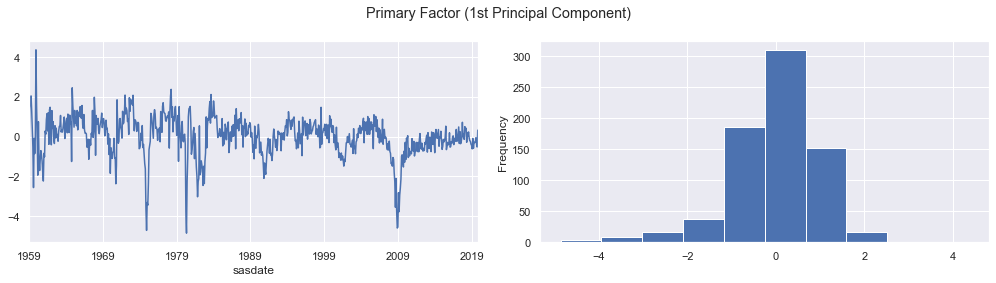

In [13]:
#Produce a histogram of the distribution of the factor, and a plot of the time series of the factor
sns.set_theme()
fig, axes = plt.subplots(1,2, figsize=(14, 4))
factor['comp_0'].plot(ax=axes[0])
factor['comp_0'].plot.hist(ax=axes[1],bins =10)
fig.figure.suptitle('Primary Factor (1st Principal Component)')
plt.tight_layout()

It is clear to see that the values of the first principal component range from -4 to 4, which are
concentrated in the range of -1 to 1. These values represent the properties of all variables so that
they correlated with the volatility of the market. For example, the very low values are compatible
with some financial crises such as The Financial Crisis of 2007–08 or The OPEC Oil Price Shock
of 1973.

### 3.1 ADL(1,1)

Here, I decided to analyse a Autoregressive Distributed Lag model (ADL) for 5 variabless 'INDPRO', 'S&P 500',
'PAYEMS', 'CPIAUCSL', 'BUSINVx'. For each variable produce a regression model using Statsmodels (sma.OLS()), regressing:
<div align="center">y(t) = a + y(t-1) + f(t-1) + e(t)

Where a is a constant, y is the transformed series at time t, y(t-1) is the transformed
series at time t-1 (i.e. the first lag produced in Q9) and f(t-1) is the factor at time t-1,
and e(t) is a zero mean error term.

In [14]:
# shift the factor time series forward by one time period
lagdt = new_df.shift(1)
lagfactor = factor.shift(1)

In [15]:
# Produce a data frame of the fitted values from my 5 models
srs_df = pd.DataFrame(index = new_df.index, columns = my_srs)

In [16]:
# Fit the model and capture the fitted values
for s in my_srs:
        reg_data = pd.concat([new_df[s],lagdt[s],lagfactor],axis =1).set_axis(['srs','lagsrs','lagfactor'],axis =1).dropna()
        yt = reg_data['srs']
        yt_1 = reg_data['lagsrs']
        ft_1 = reg_data['lagfactor']
        model = sma.OLS.from_formula('yt~1+yt_1+ft_1',data =reg_data).fit()
        srs_df[s] = model.fittedvalues
        print(s,model.summary())
srs_df.dropna(how = 'all', inplace =True)

INDPRO                             OLS Regression Results                            
Dep. Variable:                     yt   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     85.08
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           6.32e-34
Time:                        07:48:15   Log-Likelihood:                 2568.8
No. Observations:                 730   AIC:                            -5132.
Df Residuals:                     727   BIC:                            -5118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.000      6.922  

### 3.2 Plot the models

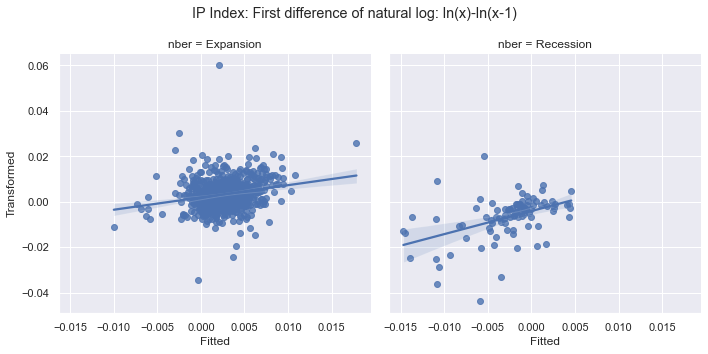

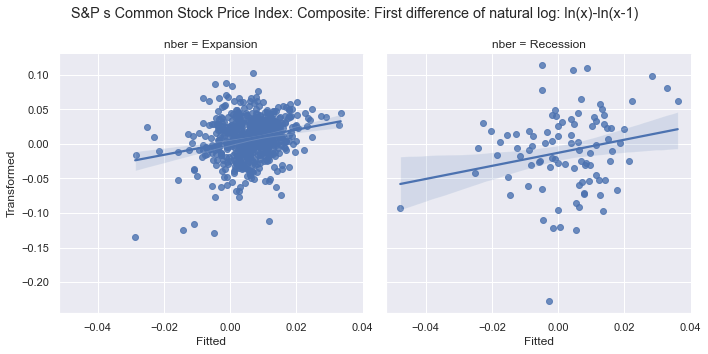

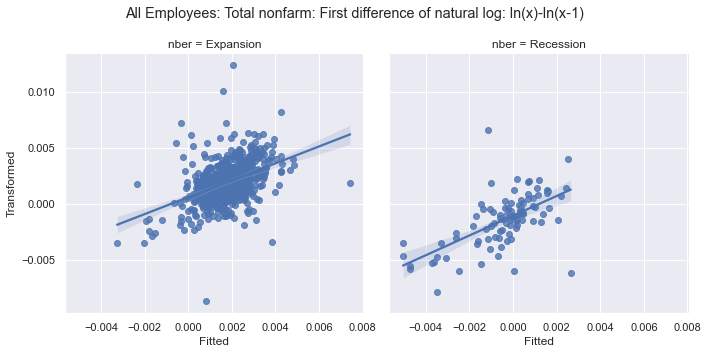

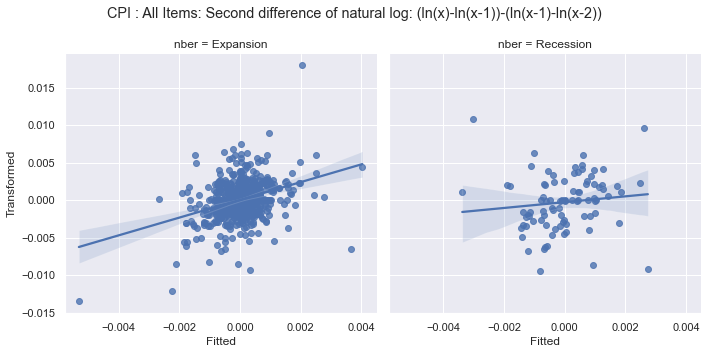

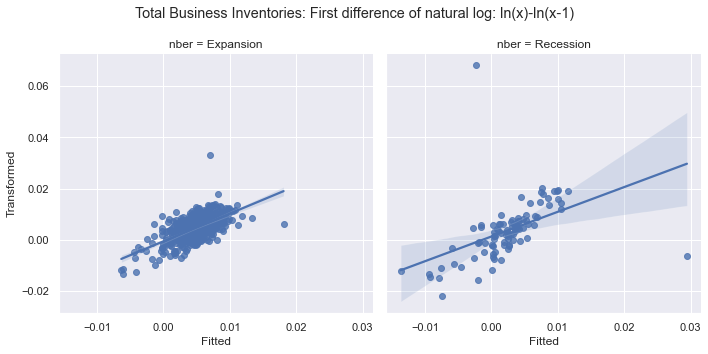

In [17]:
#Produce for each of the variables a Seaborn plot
for s in my_srs:
    srs_data = pd.concat([srs_df[s],new_df.loc["1959-03":,s],nber1],axis = 1).set_axis(['Fitted','Transformed','nber'],axis = 1)
    fig = sns.lmplot(data=srs_data, x='Fitted', y='Transformed', col='nber')
    fig.figure.suptitle(desc.loc[s,'description'] + ': '+ desc.loc[s,'ttype'])
    fig.figure.tight_layout()

The model of IP Index is quite fitted the variable. The fitted values are appropriate in both expansion (mostly bigger than 0) and recession condition (mostly smaller than 0).

The model of S&P 500 is quite fitted the variable in expansion market. However, in the recession
market, the model is not reasonably fitted the variable.

The model of All Employees: Total nonfarm is quite fitted in both markets. However, there are some observations which are extremely far from the regression line in expansion condition.

The model of CPI is quite fitted the variable in expansion market. However, in the recession market, the model is not reasonably fitted the variable.

The model of IP Index is the most fitted among 5 variables in both conditions.

## 4.Conclusion

All models for 5 variables have upward slope, and the models in expansion market
are well fitted than the model in recession market.